<a href="https://colab.research.google.com/github/juminsuh/Reinforcement_Learning/blob/main/%5B24_1_%EC%A0%95%EA%B7%9C%EC%84%B8%EC%85%98%5DSARSA%2CQ%EB%9F%AC%EB%8B%9D_%EC%A3%BC%EB%AF%BC%EC%84%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from typing import Tuple
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load env

In [ ]:
import os
os.chdir('/content/drive/MyDrive/24-1/강화학습세션/환경')

In [ ]:
!python GridWorldEnvironment2.py

In [ ]:
from GridWorldEnvironment2 import GridWorldEnvironment

# SARSA

# Agent_SA
def argmax 부분에서 왜 [0]이 붙는지 잘 모르겠어..찾아봐도 이해가 잘 안됨.ㅜ

In [ ]:
class SARSAAgent:
    def __init__(self, action_space):
        #행동에 대한 파라미터
        self.action_space=action_space #가능한 행동
        self.num_actions=len(action_space) #4개

        #학습에 관련된 파라미터
        self.step_size=0.01 #\alpha
        self.discount_factor=0.9 #\gamma
        self.epsilon=1.0
        self.epsilon_decay=0.999 #epsilon이 줄어듦
        self.epsilon_min=0.01 #epsilon이 0.01이 될 때까지

        #0을 초깃값으로 하는 큐함수 테이블 생성
        '''
        defaultdict는 self.q_table을 초기
        lamda 함수는 모든 키에 대해 모두 0으로 채워져 있는
        길이가 self.num_actions인 1차원 배열을 생성->이후 tolist()로 리스트로 변환
        따라서 self.q_table은 상태-행동 쌍을 키로, 밸류로 각 행동에 대한 초기 큐함수를 가지는
        딕셔너리가 생성
        [[0,0,0,0]]으로 초기화됨
        따라서 self.q_table[state][action]으로 밸류(큐함수)에 접근 가능
        '''
        self.q_table=defaultdict(lambda: np.zeros(self.num_actions).tolist())


        #(S,A,R,S',A') 샘플을 입력으로 받아 q_table을 업데이트
    def update_q_table(self, state, action_idx, reward, next_state, next_action_idx):
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay

        #idx로 사용하기 위해 (m,n) 좌표로 표현된 state를 문자열로 만듦
        state, next_state=str(state), str(next_state)

        #시간차 제어(SARSA)로 큐테이블을 업데이트한다
        current_q=self.q_table[state][action_idx]#현재 상태-행동 쌍의 큐함수
        next_q=self.q_table[next_state][next_action_idx]#다음 상태-행동 쌍의 큐함수
        td=reward+self.discount_factor*next_q-current_q#time difference
        new_q=current_q+self.step_size*td#큐함수 업데이트
        self.q_table[state][action_idx]=new_q#현재 상태-행동에 갱신된 큐함수 저장

        #입실론-탐욕 정책을 통해 행동을 반환
    def get_action(self, state):

        #0을 초깃값으로 하는 큐함수 테이블 생성
        #np.random.rand()은 가우시안 정규분포를 따르는 랜덤값 출력(꼭 0~1 사이값이 출력되는 것은 x)
        if np.random.rand()<self.epsilon:
            #무작위 행동 수행
            action_idx=np.random.choice(range(self.num_actions))

        else:
            #큐함수에 따른 행동
            state=str(state)
            q_list=self.q_table[state]#현재 state에 대한 네 개의 큐함수
            action_idx=self.argmax(q_list)#큐함수를 최대로 하는 action 반환

        return action_idx

    def argmax(self, q_list):
        max_value=np.amax(q_list)
        max_indices=np.where(q_list==max_value)[0]#q_list에서 max_value와 같은 값을 가지는 행동의 인덱스를 반환
        return np.random.choice(max_indices)
        '''
        np.argmax를 사용하지 않고 별도의 메소드를 정의하는 이유는
        q_table에 큐함수 값이 같은 여러 개의 action이 있다면
        그중에서 랜덤으로 선택해야 하기 때문
        '''


# main_SA

In [ ]:
#init value
env=GridWorldEnvironment(start_point=(0,0),
                         end_point=(4,4),
                         gridworld_size=(5,5))

agent=SARSAAgent(env.action_space)

EPISODES=1000
RENDER_PROCESS=False
RENDER_END=False
total_moves=[]

In [ ]:
#train code

for epi in range(EPISODES):
    #게임 환경을 초기화
    state=env.reset()
    moves_cnt=0
    #현재 상태에서 행동을 함. 입실론-탐욕 정책을 따름
    action_idx=agent.get_action(state)

    done=False #False 면 0, True면 1

    while not done:#while True

        if RENDER_PROCESS:
            env.render()

        next_state, reward, done=env.step(action_idx) #환경이 에이전트에게 제공하는 부분

        #다음 상태에서 행동을 선택한다. 이때도 입실론-탐욕 정책을 따름
        next_action_idx=agent.get_action(next_state)

        #큐함수를 업데이트한다
        agent.update_q_table(state, action_idx, reward, next_state, next_action_idx)

        state=next_state
        action_idx=next_action_idx
        moves_cnt+=1

    total_moves.append(moves_cnt)

    if(epi+1)%100==0:
        print(f"[Episode]:{epi+1}/{EPISODES}__[Num of Moves Mean]:{np.mean(total_moves[epi-99:]):.1f}__[Epsilon]:{agent.epsilon:.3f}")



[Episode]:100/1000__[Num of Moves Mean]:18.1__[Epsilon]:0.164
[Episode]:200/1000__[Num of Moves Mean]:9.0__[Epsilon]:0.066
[Episode]:300/1000__[Num of Moves Mean]:8.2__[Epsilon]:0.029
[Episode]:400/1000__[Num of Moves Mean]:8.1__[Epsilon]:0.013
[Episode]:500/1000__[Num of Moves Mean]:8.1__[Epsilon]:0.010
[Episode]:600/1000__[Num of Moves Mean]:8.1__[Epsilon]:0.010
[Episode]:700/1000__[Num of Moves Mean]:8.1__[Epsilon]:0.010
[Episode]:800/1000__[Num of Moves Mean]:8.1__[Epsilon]:0.010
[Episode]:900/1000__[Num of Moves Mean]:8.2__[Epsilon]:0.010
[Episode]:1000/1000__[Num of Moves Mean]:8.1__[Epsilon]:0.010


In [ ]:
env.render()

S X . . . 
. X X . . 
. . X X X 
. . . . X 
. . . . A 



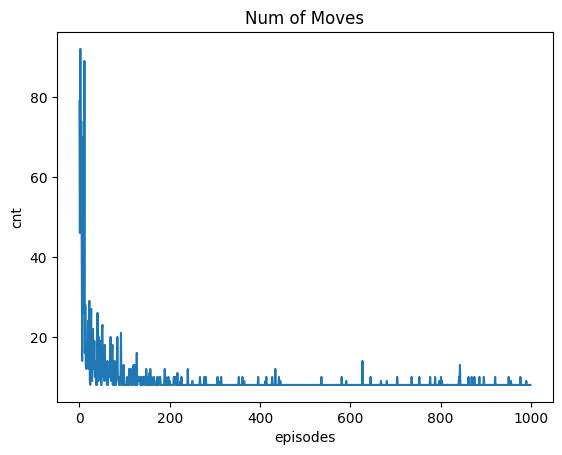

In [ ]:
#1000개의 에피소드에서 에이전트의 이동 횟수를 시각화
plt.plot(total_moves)
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

# Q-Learning

# Agent_QL

In [ ]:
class QlearningAgent:
    def __init__(self, action_space):
        #행동에 관한 파라미터
        self.action_num=action_space
        self.num_actions=len(action_space)

        #학습에 관련된 파라미터
        self.step_size=0.01
        self.discount_factor=0.9
        self.epsilon=1.0
        self.epsilon_decay=0.999
        self.epsilon_min=0.01

        '''
        0을 초깃값으로 하는 큐함수 테이블 생성.
        상태-행동 쌍을 키로 하고 행동에 따른 큐함수를 밸류로 하는 딕셔너리 생성
        '''
        self.q_table=defaultdict(lambda: np.zeros(self.num_actions).tolist())

        #next_action_idx가 필요 없음
    def update_q_table(self, state, action_idx, reward, next_state):
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay

        state, next_state=str(state), str(next_state)

        q_1=self.q_table[state][action_idx]#state의 action_idx에 해당하는 큐함수

        #벨만 최적 방정식을 이용, next_action_idx는 알 필요 없음
        q_2=reward+self.discount_factor*max(self.q_table[next_state])
        self.q_table[state][action_idx]+=self.step_size*(q_2-q_1)

    def get_action(self, state):
        '''
        입실론-탐욕 정책에 따라 행동 선택
        '''
        #0을 초깃값으로 하는 큐함수 테이블 생성
        if np.random.rand()<self.epsilon:
            #무작위 행동 수행
            action_idx=np.random.choice(range(self.num_actions))
        else:
            #큐함수에 따른 행동
            state=str(state)
            q_list=self.q_table[state]
            action_idx=self.argmax(q_list)

        return action_idx

    def argmax(self, q_list):
        max_value=np.amax(q_list)
        max_indices=np.where(q_list==max_value)[0]

        return random.choice(max_indices)



# main_QL

In [ ]:
# init value
env=GridWorldEnvironment(start_point=(0,0),
                         end_point=(4,4),
                         gridworld_size=(5,5))
agent=QlearningAgent(env.action_space)

EPISODES=1000
RENDER_PROCESS=False
RENDER_END=False
total_moves=[]

In [ ]:
#train code

for epi in range(EPISODES):
    #게임 환경을 초기화
    state=env.reset()
    moves_cnt=0

    done=False

    while not done:
        if RENDER_PROCESS:
            env.render()

        #현재 상태에 대한 행동 선택
        action_idx=agent.get_action(state)
        #취한 행동에 대한 next_state, reward, done을 환경이 제공함
        next_state, reward, done=env.step(action_idx)

        #큐함수를 업데이트(S, A, R, S')
        #현재 상태의 행동 action_idx는 입실론-탐욕 정책을 따른 것
        agent.update_q_table(state, action_idx, reward, next_state)

        state=next_state
        moves_cnt+=1

    total_moves.append(moves_cnt)

    if (epi+1)%100==0:
        print(f"[Episode]:{epi+1}/{EPISODES}__[Num of Moves mean]:{np.mean(total_moves[epi-99:]):.1f}__[Epsilon]:{agent.epsilon:.03f}")
    if RENDER_END:
        env.render()

[Episode]:100/1000__[Num of Moves mean]:17.2__[Epsilon]:0.178
[Episode]:200/1000__[Num of Moves mean]:8.9__[Epsilon]:0.073
[Episode]:300/1000__[Num of Moves mean]:8.5__[Epsilon]:0.031
[Episode]:400/1000__[Num of Moves mean]:8.2__[Epsilon]:0.014
[Episode]:500/1000__[Num of Moves mean]:8.0__[Epsilon]:0.010
[Episode]:600/1000__[Num of Moves mean]:8.1__[Epsilon]:0.010
[Episode]:700/1000__[Num of Moves mean]:8.1__[Epsilon]:0.010
[Episode]:800/1000__[Num of Moves mean]:8.1__[Epsilon]:0.010
[Episode]:900/1000__[Num of Moves mean]:8.1__[Epsilon]:0.010
[Episode]:1000/1000__[Num of Moves mean]:8.1__[Epsilon]:0.010


In [ ]:
env.render()

S . . . . 
X . . . . 
X X X X . 
. . . X X 
. . . . A 



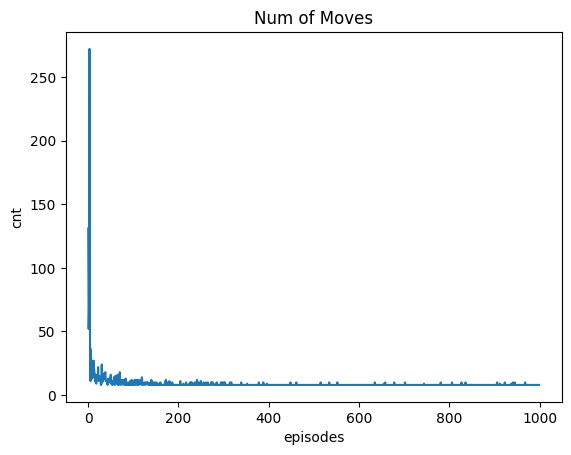

In [ ]:
#1000개의 에피소드에서 에이전트의 이동 횟수를 시각화
plt.plot(total_moves)
plt.ylabel('cnt')
plt.xlabel('episodes')
plt.title('Num of Moves')
plt.show()